# Plot GHG fluxes and ST contribution as a function of wind direction

In [2]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pickle
import cloudpickle

import pymc as pm
import arviz as az

import seaborn as sns

from py_markdown_table.markdown_table import markdown_table

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define onedrive folder location

In [3]:
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

## Load L2 data

In [4]:
data = xr.open_dataset(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2022_20240607.nc')

In [5]:
data

<xarray.Dataset>
Dimensions:                     (time: 19344, soil_class: 10)
Coordinates:
  * time                        (time) datetime64[ns] 2021-11-24 ... 2022-12-...
  * soil_class                  (soil_class) <U16 'Fallen tree' ... 'Instrume...
Data variables: (12/103)
    H                           (time) float64 ...
    H_qf                        (time) float64 ...
    H_final                     (time) float64 ...
    rand_err_H                  (time) float64 ...
    LE                          (time) float64 ...
    LE_qf                       (time) float64 ...
    ...                          ...
    T_air_tomst_plot_3          (time) float64 ...
    soil_moisture_tomst_plot_3  (time) float64 ...
    T_soil_tomst_plot_4         (time) float64 ...
    T_surface_tomst_plot_4      (time) float64 ...
    T_air_tomst_plot_4          (time) float64 ...
    soil_moisture_tomst_plot_4  (time) float64 ...

In [6]:
data = data.sel(time=slice(datetime(2022,5,1), datetime(2022,11,16)))

In [7]:
data['soil_class'] = np.array(['Dead wood','Harvest residue','Exposed peat','Litter','Bottom layer (mosses)','Field layer','Ditch (water surface)', 'Living tree', 'Plant covered ditch','Instruments'])

In [8]:
(np.nanmin(data.TA_1_1_1), np.nanmax(data.TA_1_1_1))

(-8.9926, 31.3745)

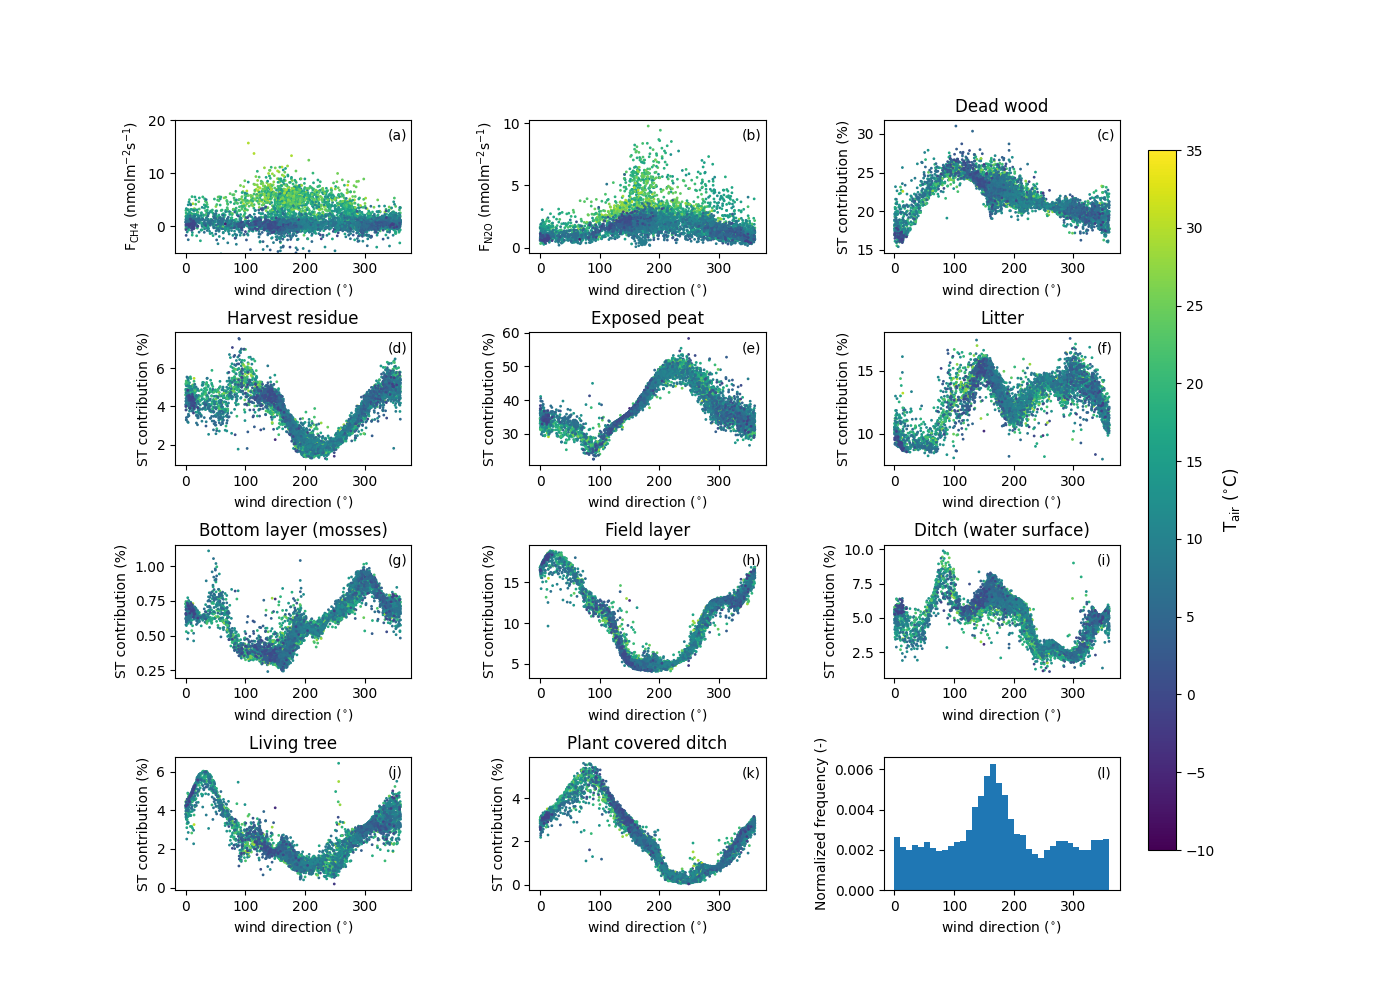

In [9]:
fig, axs = plt.subplots(figsize=(14,10), nrows=4, ncols=3)
fig.subplots_adjust(wspace=0.5, hspace=0.6, right=0.8)
axs = axs.flatten()

im = axs[0].scatter(data.wind_dir, data.ch4_flux_final*1000, c=data.TA_1_1_1, s=1, vmin=-10, vmax=35)
axs[1].scatter(data.wind_dir, data.n2o_flux_final*1000, c=data.TA_1_1_1, s=1, vmin=-10, vmax=35)

for i in range(2,11):
    axs[i].set_title(data['soil_class'].data[i-2])
    axs[i].scatter(data.wind_dir, data.fpr_contribution[i-2, :]*100, c=data.TA_1_1_1, s=1, vmin=-10, vmax=35)

_ = axs[-1].hist(data.wind_dir, bins=np.linspace(0, 360, 37), density=True)

subplot_labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
for i,ax in enumerate(axs):
    if i == 0:
        ax.set_ylabel('F$_{\mathrm{CH4}}$ ($\mathrm{nmol m^{-2}s^{-1}}$)')
    elif i==1:
        ax.set_ylabel('F$_{\mathrm{N2O}}$ ($\mathrm{nmol m^{-2}s^{-1}}$)')
    elif i==11:
        ax.set_ylabel('Normalized frequency (-)')
    else:
        ax.set_ylabel('ST contribution (%)')
    ax.set_xlabel('wind direction $(^{\circ})$')
    ax.text(0.9, 0.85, subplot_labels[i], transform=ax.transAxes)

cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('T$_{\mathrm{air}}$ ($^{\circ}$C)', fontsize=12)

_ = axs[0].set_ylim([-5, 20])


In [10]:
np.exp(-6.5)*1000

1.5034391929775723